In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd.function import Function
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import sys

%matplotlib inline

In [2]:
# Create device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Load MNIST dataset and create dataloaders
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('./mnist', train=True, download=True, transform=transform)
test_dataset = MNIST('./mnist', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [4]:
class LeNet(nn.Module):
    """ Implementation LeNet++ """
    
    def __init__(self, final_layer):
        super(LeNet, self).__init__()
        
        channels_stage1 = 32
        channels_stage2 = 64
        channels_stage3 = 128
        
        # Save result of stage 4 to use in center loss
        self.stage4_result = np.zeros((10, 2))
        
        # Layers of network
        # Stage 1
        self.stage1 = nn.Sequential(nn.Conv2d(1, channels_stage1, 5, stride=1, padding=2), nn.PReLU(),
                                   nn.Conv2d(channels_stage1, channels_stage1, 5, stride=1, padding=2), nn.PReLU(),
                                   nn.MaxPool2d(2, stride=2, padding=0))
        
        # Stage 2
        self.stage2 = nn.Sequential(nn.Conv2d(channels_stage1, channels_stage2, 5, stride=1, padding=2), nn.PReLU(),
                                   nn.Conv2d(channels_stage2, channels_stage2, 5, stride=1, padding=2), nn.PReLU(),
                                   nn.MaxPool2d(2, stride=2, padding=0))
        
        # Stage 3
        self.stage3 = nn.Sequential(nn.Conv2d(channels_stage2, channels_stage3, 5, stride=1, padding=2), nn.PReLU(),
                                   nn.Conv2d(channels_stage3, channels_stage3, 5, stride=1, padding=2), nn.PReLU(),
                                   nn.MaxPool2d(2, stride=2, padding=0))
        
        # Stage 4, size = 28(image_size) / 2**3(3 x MaxPool(2))
        self.stage4 = nn.Sequential(nn.Linear(3*3*channels_stage3, 2), nn.PReLU())
        
        # Stage 5, we have 10 numbers and we need 10 outputs
        self.stage5 = nn.Sequential(nn.Linear(2, 10), final_layer)

    def forward(self, x):
        """ Implement forward path """
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = x.view(x.size(0), -1)
        
        # Save result to use in Center Loss
        self.stage4_result = self.stage4(x)
        
        output = self.stage5(self.stage4_result)
        return output
    
    def get_stage4(self):
        """ Return saved result for use in Center Loss """
        return self.stage4_result

In [5]:
class CenterLossFunc(Function):
    @staticmethod
    def forward(ctx, centers, outputs, y):
        ctx.save_for_backward(centers, outputs, y)
        indexing_centers = torch.index_select(centers, 0, y)
        return (outputs - indexing_centers).pow(2).sum() / (2.0 * y.shape[0])
    
    @staticmethod
    def backward(ctx, grad_output):
        centers, fc_outputs, y = ctx.saved_tensors
        delta = torch.zeros(10,2).to(device)
        len_sum = torch.histc(y.cpu().data.float(), bins=10, min=0, max=9).to(device)
        len_sum += 1
        indexing_centers = torch.index_select(centers, 0, y)
        grad = fc_outputs - indexing_centers
        for i in range(y.shape[0]):
            delta[y[i]] += indexing_centers.data[i].to(device) - fc_outputs[i]
        delta /= len_sum.view(-1, 1) 
        grad_output.data = grad_output.data.view(-1, 1) * grad
        return delta, grad_output, None

In [6]:
class CenterLoss(nn.Module):
    """ Implementation center loss """
    
    def __init__(self):
        super(CenterLoss, self).__init__()
        self.centers = nn.Parameter(torch.zeros((10, 2)))
        
    def forward(self, outputs, y):
        return CenterLossFunc.apply(self.centers, outputs, y)
    
    def get_centers(self):
        return self.centers.detach().cpu().data.numpy()

In [7]:
def metrics_plot(train_loss_epochs, test_loss_epochs, train_acc_epochs, test_acc_epochs):
        """ Draw plots for metrics """
        
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_loss_epochs[1:], label='Train')
        plt.plot(test_loss_epochs[1:], label='Test')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Loss', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.grid('on')
        plt.subplot(1, 2, 2)
        plt.plot(train_acc_epochs[1:], label='Train')
        plt.plot(test_acc_epochs[1:], label='Test')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Accuracies', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.grid('on')
        plt.show()
    
def activation_plot(accumulate_layer_train, accumulate_layer_test, y_train, y_test, centers):
    """ Draw plots for neuron's activation """
    
    plt.figure(figsize=(20, 10))
    for x in range(10):
        plt.subplot(1, 2, 1)
        plt.scatter(accumulate_layer_train[:, 0][y_train == x], 
                    accumulate_layer_train[:, 1][y_train == x], 
                    label=str(x), s=2)
        
        plt.subplot(1, 2, 2)
        plt.scatter(accumulate_layer_test[:, 0][y_test == x], 
                    accumulate_layer_test[:, 1][y_test == x], 
                    label=str(x), s=2)
        
    plt.subplot(1, 2, 1)
    plt.scatter(centers[:, 0], centers[:, 1], s=30)
    plt.title("Train")
    plt.xlabel('Activation of the 1st neuron', fontsize=12)
    plt.ylabel('Activation of the 2nd neuron', fontsize=12)
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.scatter(centers[:, 0], centers[:, 1], s=30)
    plt.title("Test")
    plt.xlabel('Activation of the 1st neuron', fontsize=12)
    plt.ylabel('Activation of the 2nd neuron', fontsize=12)
    plt.legend()
    plt.show()

In [8]:
def train(network, epochs, main_lr=1e-4, center_lr=0.5, _lambda=0.5, 
          draw_metrics_plot=True, draw_activation_plot=False, debug=True, 
          standart_loss=nn.NLLLoss().to(device), center_loss=CenterLoss().to(device),
          optim=torch.optim.Adam, center_optim=torch.optim.SGD):
    """ Train network and collect metrics """
    
    # Arrays for metrics
    train_loss_epochs = []
    train_acc_epochs = []
    test_loss_epochs = []
    test_acc_epochs = []
    
    # Initialised optimizers
    optimizer = optim(network.parameters(), lr=main_lr)
    center_optimizer = center_optim(center_loss.parameters(), lr=center_lr, momentum=0.9)
    
    if draw_activation_plot:
        accumulate_layer_train = []
        accumulate_layer_test = []
        y_train = []
        y_test = []
    
    # Start main loop with train and test step
    try:
        for epoch in range(epochs):
            loss_epoch = []
            acc_epoch = []
            
            # Train step
            for i, sample in enumerate(train_loader):
                if debug:
                    sys.stdout.write('\rEpoch {0}... Train: {1:d}/{2:d}'.format(
                        epoch, i, len(train_loader)))
                
                # Get new sample of batch
                X, y = sample
                X = X.to(device)
                y = y.to(device)
                
                # Make prediction on batch
                prediction = network(X)
                
                if draw_activation_plot:
                    accumulate_layer_train.extend(network.get_stage4().cpu().data.numpy())
                    y_train.extend(y.cpu().data.numpy())
                        
                # Calculate loss, make backward and make optimizers step
                loss_batch = standart_loss(prediction, y) + _lambda * center_loss(network.get_stage4(), y)
                optimizer.zero_grad()
                center_optimizer.zero_grad()
                
                loss_batch.backward()
                
                optimizer.step()
                center_optimizer.step()
                
                # Calculate metrics
                acc_batch = (np.argmax(prediction.cpu().data.numpy(), 1) == y.cpu().data.numpy()).mean()
                loss_epoch.append(loss_batch.data[0])
                acc_epoch.append(acc_batch)
                
            # Get average metrics by epoch for train step
            train_loss_epochs.append(np.mean(loss_epoch))
            train_acc_epochs.append(np.mean(acc_epoch))
            
            loss_epoch = []
            acc_epoch = []
            
            # Test step
            for i, sample in enumerate(test_loader):
                if debug:
                    sys.stdout.write('\rEpoch {0}... Test: {1:d}/{2:d}'.format(
                        epoch, i, len(test_loader)))
                
                # Get new sample of batch
                X, y = sample
                X = X.to(device)
                y = y.to(device)
                
                # Get predict of batch and calculate loss
                prediction = network(X)
                
                if draw_activation_plot:
                    accumulate_layer_test.extend(network.get_stage4().cpu().data.numpy())
                    y_test.extend(y.cpu().data.numpy())
                        
                # Calculate loss
                loss_batch = standart_loss(prediction, y) + _lambda * center_loss(network.get_stage4(), y)
                
                # Calculate metrics
                acc_batch = (np.argmax(prediction.cpu().data.numpy(), 1) == y.cpu().data.numpy()).mean()
                loss_epoch.append(loss_batch.data[0])
                acc_epoch.append(acc_batch)
            
            # Get average metrics by epoch for test step
            test_loss_epochs.append(np.mean(loss_epoch))
            test_acc_epochs.append(np.mean(acc_epoch))
            if debug:
                sys.stdout.write('\rEpoch {0}... (Train/Test)  Loss: {1:.3f}/{2:.3f}...  Acc: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                               train_acc_epochs[-1], test_acc_epochs[-1]))
        
        #Draw metrics plot if needed
        if draw_metrics_plot:
            metrics_plot(train_loss_epochs, test_loss_epochs, train_acc_epochs, test_acc_epochs)
        
        if draw_activation_plot:
            accumulate_layer_train = np.array(accumulate_layer_train)
            accumulate_layer_test = np.array(accumulate_layer_test)
            y_train = np.array(y_train)
            y_test = np.array(y_test)
            activation_plot(accumulate_layer_train, accumulate_layer_test, y_train, y_test, center_loss.get_centers())
            
    except KeyboardInterrupt:
        pass

In [9]:
# Create 3 models for 3 case(lambda = 0, 0.1, 1)
final_loss = nn.LogSoftmax(dim=1)
model = LeNet(final_loss).to(device)
model2 = LeNet(final_loss).to(device)

### Start train model and draw plots with lambda=0

Epoch 0... Train: 3/469

/home/anton.loskutov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 0... Test: 4/79/469

/home/anton.loskutov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:92: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 29... (Train/Test)  Loss: 0.019/0.207...  Acc: 0.994/0.978

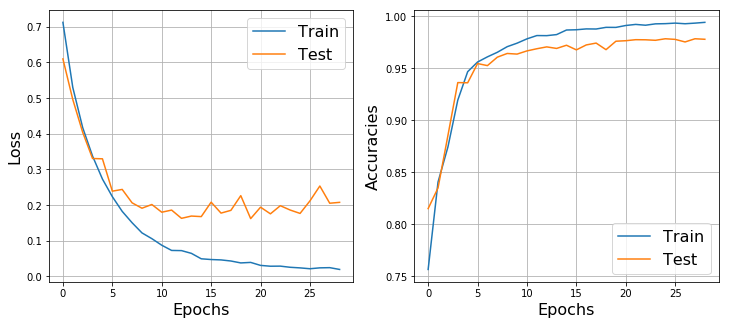

Epoch 0... (Train/Test)  Loss: 0.020/0.210...  Acc: 0.994/0.978

/home/anton.loskutov/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


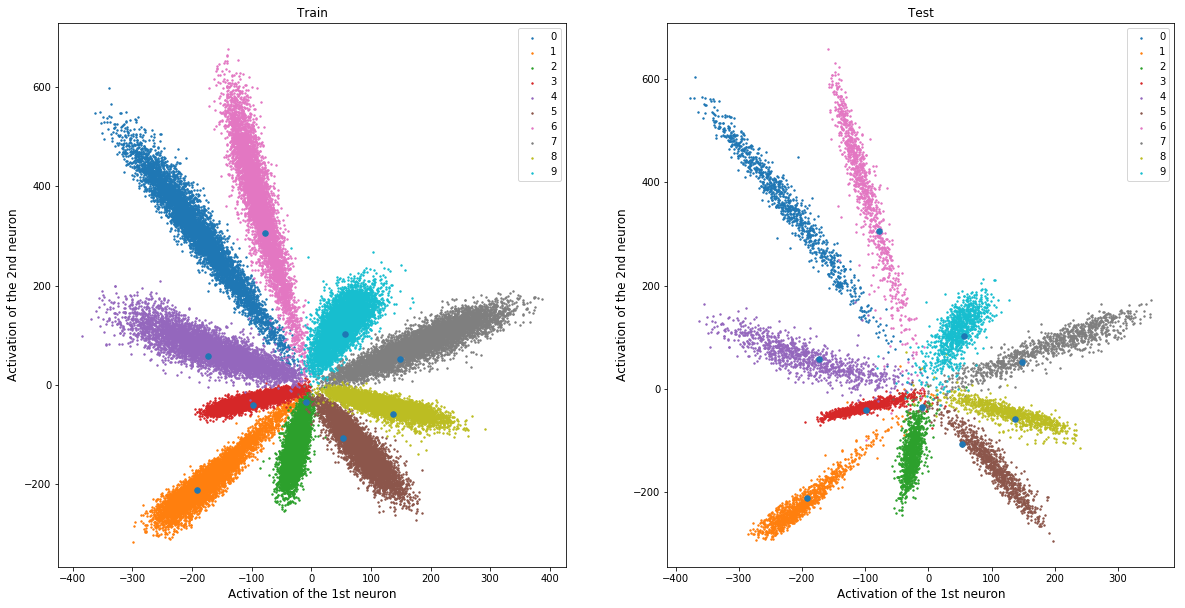

In [10]:
train(model, epochs=30, _lambda=0, draw_activation_plot=False)
train(model, epochs=1, _lambda=0, draw_metrics_plot=False, draw_activation_plot=True)

### Train model and draw plots with lambda = 0.1

Epoch 0... Train: 3/469

/home/anton.loskutov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 0... Test: 0/79/469

/home/anton.loskutov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:92: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 99... (Train/Test)  Loss: 0.097/0.147...  Acc: 0.999/0.989

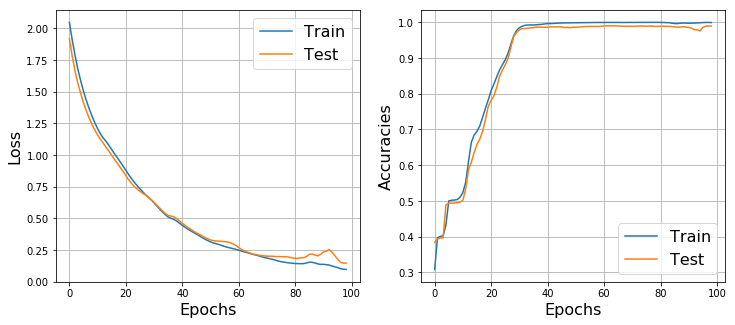

Epoch 0... (Train/Test)  Loss: 0.096/0.140...  Acc: 0.999/0.990

/home/anton.loskutov/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


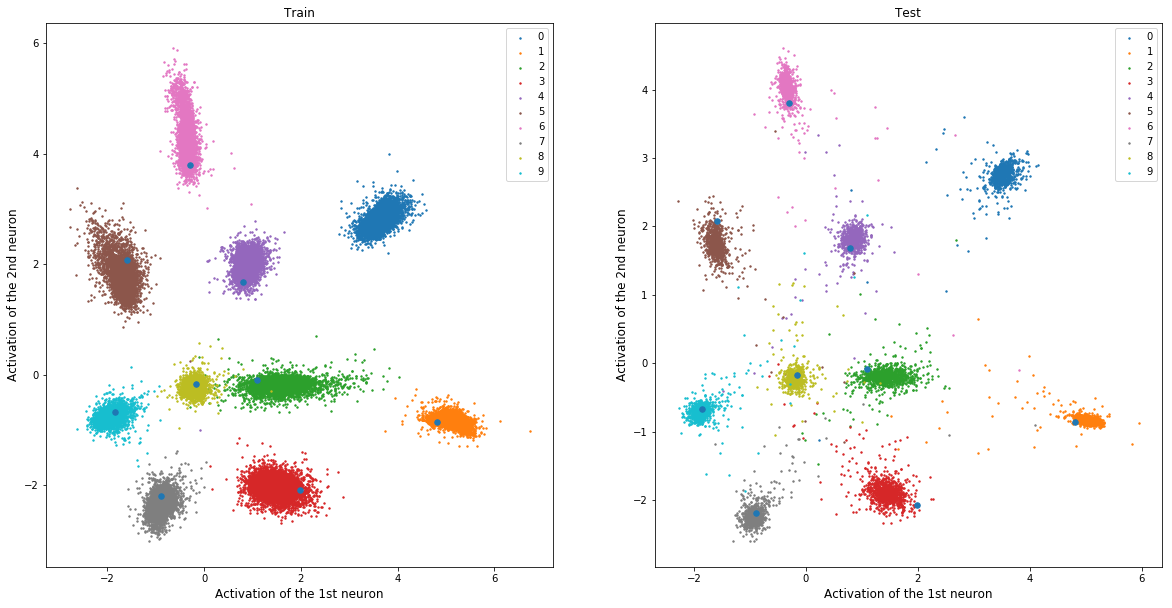

In [10]:
train(model, epochs=100, _lambda=0.1, draw_activation_plot=False)
train(model, epochs=1, _lambda=0.1, draw_metrics_plot=False, draw_activation_plot=True)

### Train model and draw plots with lambda=1

Epoch 0... Train: 3/469

/home/anton.loskutov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 0... Test: 7/79/469

/home/anton.loskutov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:92: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 24... (Train/Test)  Loss: 0.064/0.120...  Acc: 1.000/0.990

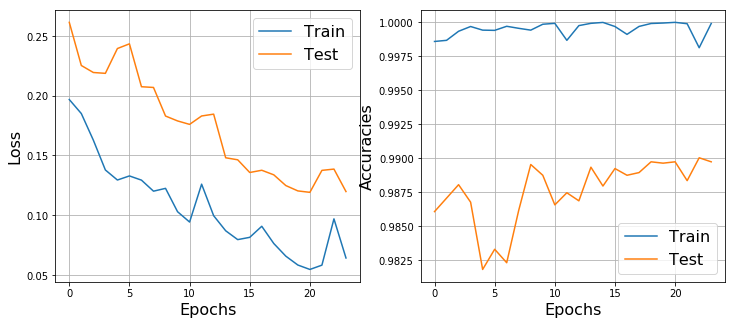

Epoch 0... (Train/Test)  Loss: 0.054/0.116...  Acc: 1.000/0.990

/home/anton.loskutov/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


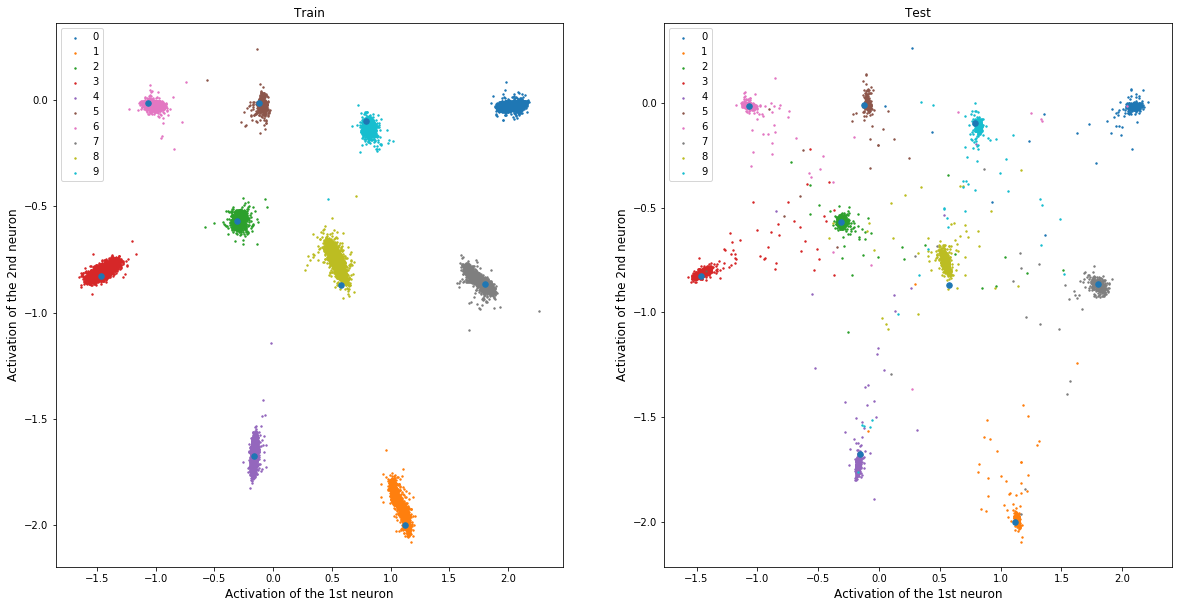

In [13]:
train(model2, epochs=25, _lambda=1, main_lr=3e-4, draw_activation_plot=False)
train(model2, epochs=1, _lambda=1, draw_metrics_plot=False, draw_activation_plot=True)